In [1]:
import numpy as np
import polars as pl
import sys, os

os.chdir('/home/bcaron/Storage/Dropbox/CBL/NCBoost/NCBoost-2')

## 1 - Load and annotate variants
This first section load the training positive & negative variant sets.
It requires the user to provide a set of positive and negative variants, containing at least:

chr: str, chromosome bearing the variant, [1:22], X, Y

pos: int, hg38 genomic position of the variant

ref: str, reference allele at the position

alt: str, alternative allele at the position

If NCBoost 2 feature file was not downloaded, please directly run section 2.


In [2]:
from src.ncboost_functions import add_ncboost_features

In [3]:
positives =  pl.read_csv(source='data/training/positives_for_training.tsv',
                         separator = '\t',
                         schema_overrides = {'chr' : str},
                         null_values = 'NA'
                         )
positives = add_ncboost_features(positives, db_path='data/WG_annotated')
positives = positives.drop('NCBoost')
positives = positives.with_columns(label=1)
print(positives.shape)
positives.head()

Chromosome:   0%|          | 0/24 [00:00<?, ?it/s]

gzip: data/WG_annotated/WG_chr1.tsv.gz: No such file or directory
open: No such file or directory


TabixError: Can't open the index file.

In [ ]:
negatives =  pl.read_csv(source=f'data/training/negatives_for_training.tsv', 
                         separator='\t',
                         schema_overrides={'chr' : str},
                         null_values='NA'
                         )
negatives = add_ncboost_features(negatives, db_path='data/WG_annotated')
negatives = negatives.drop('NCBoost')
negatives = negatives.with_columns(label=0)
print(negatives.shape)
negatives.head()

Chromosomes:   0%|          | 0/22 [00:00<?, ?it/s]

(2340, 68)


chr,pos,ref,alt,matching_index,region,closest_gene_name,closest_gene_ENSG,paml_dnds,slr_dnds,paml_pvalue,paml_bh,gene_age,pLI,zscore_mis,zscore_syn,loeuf,GDI,ncRVIS,ncGERP,RVIS_percentile,pcGERP,CADD_ENSG,CADD_GeneName,GC,CpG,priPhCons,mamPhCons,verPhCons,priPhyloP,mamPhyloP,verPhyloP,bStatistic,GerpRS,GerpRSpval,GerpN,GerpS,Aparent2,ZooPriPhyloP,ZooVerPhyloP,ZooRoCC,ZooUCE,Roulette-FILTER,Roulette-MR,Roulette-AR,CADD,CADD_phred,CDTS,mean_MAF,mean_MAF_afr,mean_MAF_ami,mean_MAF_amr,mean_MAF_asj,mean_MAF_eas,mean_MAF_fin,mean_MAF_mid,mean_MAF_nfe,mean_MAF_sas,ReMM,SpliceAI,UTR3,UTR5,downstream,intergenic,intronic,upstream,partition,label
str,i64,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i32
"""9""",95516906,"""T""","""A""",0,"""UTR5""","""PTCH1""","""ENSG00000185920""","""0.0551""","""0.053""","""0.0002535""","""0.002894""","""0.0""","""1.0""","""3.1493""","""-0.19741""","""0.146""","""6145.45731""","""0.3059783363""","""1.334296224""","""0.7077140835""","""31.9450431034""","""NA""","""NA""","""0.543""","""0.107""","""0.994""","""1.0""","""1.0""","""0.44""","""2.992""","""5.817""","""358.0""","""4245.19""","""0.0""","""5.73""","""5.73""","""NA""","""1.0""","""6.06""","""28.0""","""NA""","""TFBS""","""0.03""","""NA""","""2.798946""","""20.3""","""-13.6727""","""0.0010151133252671756""","""0.0028859213673267325""","""0.062238562500000004""","""0.003319927541509434""","""0.03117590054545455""","""0.00675149429032258""","""0.02119578049285714""","""0.030591071111111107""","""0.0020852149916030533""","""0.004207994097560975""","""0.998548""","""NA""","""0""","""1""","""0""","""0""","""0""","""0""","""10""",0
"""9""",105448019,"""C""","""T""",0,"""UTR5""","""FSD1L""","""ENSG00000106701""","""0.04331""","""0.04032""","""0.4868""","""0.8088""","""0.0""","""0.033382""","""1.2852""","""0.13431""","""0.838""","""149.46024""","""NA""","""0.02638081""","""91.4248643548""","""17.7693965517""","""NA""","""NA""","""0.755""","""0.28""","""0.924""","""0.013""","""0.02""","""0.418""","""0.166""","""0.273""","""961.0""","""NA""","""NA""","""4.9""","""1.96""","""NA""","""0.994""","""1.608""","""NA""","""NA""","""TFBS""","""0.041""","""0.041""","""1.903724""","""16.3""","""-13.1197""","""0.00346955323555184""","""0.006144258628461539""","""0.12904476125""","""0.019366471059090905""","""0.06473024216666666""","""0.0335102020882353""","""0.05453979845499999""","""0.07536214307692307""","""0.007221977754193549""","""0.02065586715""","""0.943829""","""NA""","""0""","""1""","""0""","""0""","""0""","""0""","""10""",0
"""9""",133479446,"""G""","""A""",17,"""upstream""","""SLC2A6""","""ENSG00000160326""","""0.06971""","""0.06237""","""0.3465""","""0.6425""","""0.0""","""4.9492e-14""","""0.13567""","""-1.4601""","""1.325""","""266.02217""","""-0.0332604877""","""-0.96074429""","""37.6032083038""","""59.6713362069""","""NA""","""NA""","""0.695""","""0.24""","""0.082""","""0.0""","""0.001""","""-0.388""","""0.317""","""0.727""","""763.0""","""NA""","""NA""","""2.65""","""0.641""","""NA""","""0.001""","""1.194""","""NA""","""NA""","""TFBS""","""0.342""","""0.301""","""0.887557""","""9.136""","""-20.7804""","""0.0011213516038571431""","""0.003370741967326733""","""0.12320301""","""0.005141847325454544""","""0.04222400875""","""0.004151339083333332""","""0.026994121775""","""0.09863965999999999""","""0.0021608132602564103""","""0.0036780998666666657""","""0.818869""","""NA""","""0""","""0""","""0""","""0""","""0""","""1""","""10""",0
"""9""",122391161,"""C""","""T""",18,"""intronic""","""PTGS1""","""ENSG00000095303""","""0.08162""","""0.08055""","""0.03081""","""0.1137""","""0.0""","""2.735e-9""","""1.44""","""0.50015""","""0.82""","""550.09831""","""0.9390539779""","""0.001629208""","""88.8476055674""","""40.2963362069""","""NA""","""NA""","""0.397"

In [ ]:
positives.write_csv(file='data/training/positives_annotated.tsv',
                    separator="\t", 
                    include_header=True,
                    null_value='NA'
                    )
negatives.write_csv(file='data/training/negatives_annotated.tsv', 
                    separator="\t", 
                    include_header=True,
                    null_value='NA'
                    )

## 2 - Training NCBoost framework

In [7]:
from src.ncboost_functions import get_feature_list

A, B, C, D = get_feature_list()
variables = ['chr', 'pos', 'ref', 'alt', 'region', 'closest_gene_name', 'closest_gene_ENSG', 
             'label', 'partition', 'matching_index', 'CADD', 'ReMM']
region_list = ['upstream', 'downstream', 'intronic', 'UTR5', 'UTR3', 'intergenic']
features = A + B + C + D + region_list


In [8]:
from src.ncboost_functions import ncboost_train
model_name = f'toy_models'
save_path = f'models/{model_name}'
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [ ]:
positives =  pl.read_csv(source = 'data/training/positives_annotated.tsv', 
                   separator = '\t',
                   schema_overrides = {'chr' : str},
                   null_values='NA',
                   )

negatives =  pl.read_csv(source = 'data/training/negatives_annotated.tsv', 
                   separator = '\t',
                   schema_overrides = {'chr' : str},
                   null_values='NA',
                   )

In [10]:
data = pl.concat([negatives.select(variables + features), positives.select(variables + features)], how = 'vertical')

model_dict, feature_importance, annotated_data = ncboost_train(data, features, save_path)

Training model 1
Training model 2
Training model 3
Training model 4
Training model 5
Training model 6
Training model 7
Training model 8
Training model 9
Training model 10


In [11]:
annotated_data.write_csv(file = f'{save_path}/training_data_scored.tsv', 
                        separator = "\t", 
                        include_header = True,
                        null_value = 'NA'
                        )

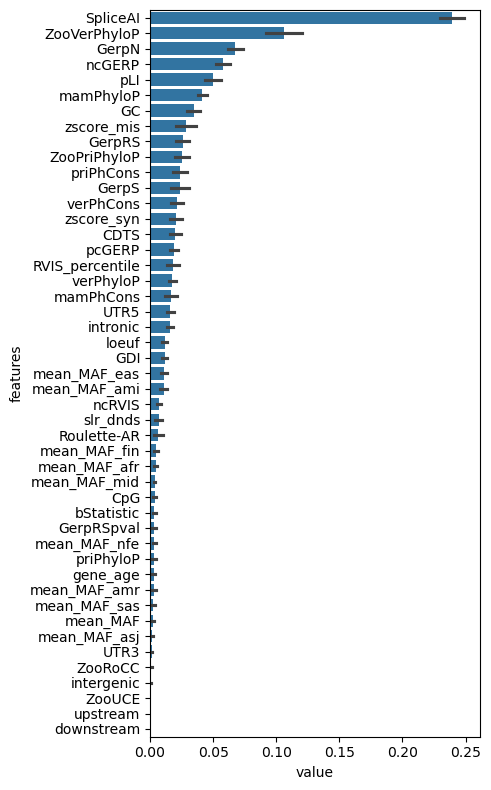

In [12]:
feature_importance =  pl.read_csv(source = f'{save_path}/feature_importance.tsv', 
                   separator = '\t',
                   null_values='NA',
                   )
from src.ncboost_functions import plot_feature_importance
plot_feature_importance(feature_importance, save_path)

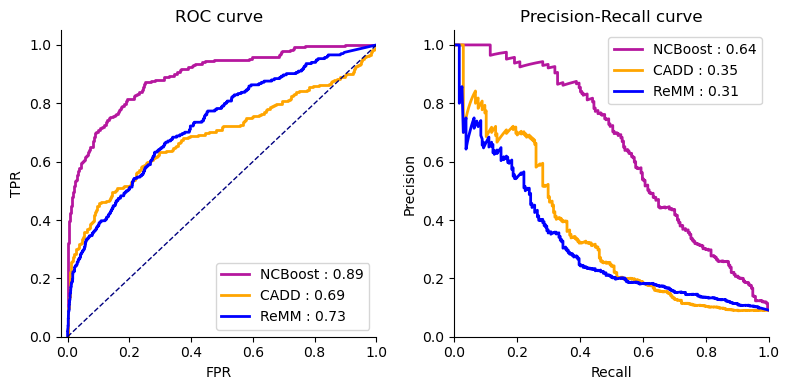

In [13]:
annotated_data =  pl.read_csv(source = f'{save_path}/training_data_scored.tsv', 
                   separator = '\t',
                   null_values='NA',
                   schema_overrides={'chr':str}
                   )
from src.ncboost_functions import plot_roc_prc
plot_roc_prc(annotated_data, save_path, scores = ['NCBoost', 'CADD', 'ReMM'])